In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [19]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from data_analysis import *

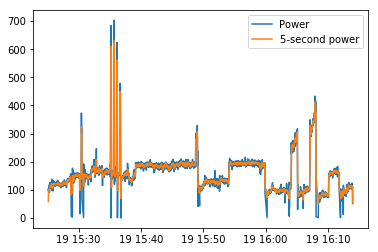

In [23]:
df = load_file('5G0G6PsD9V_AuE1AfVSBX.tcx')
# df = load_file('Afternoon_Ride.gpx')
df['5-second Watts'] = get_ns_power(df, 5)
plt.plot(df.index, df['Watts'], label='Power')
plt.plot(df.index, df['5-second Watts'], label='5-second power')
plt.legend();

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tcx_data_analysis as tda
import gpx_data_analysis as gda

Load in the TCX file as a pandas DataFrame:

In [5]:
fname = '5G0G6PsD9V_BPks5swZpa.tcx'

In [6]:
if fname.split('.')[-1] == 'tcx':
    df = tda.tcx_to_dataframe(fname)
elif fname.split('.')[-1] == 'gpx':
    df = gda.gpx_to_dataframe(fname)

In [7]:
df.sample(10)

,time,power,cadence,speed,hr,distance
501,2019-01-30 15:01:02,163.0,92.0,9.54,153.0,4400.98
132,2019-01-30 14:54:53,93.0,79.0,7.74,126.0,1046.77
441,2019-01-30 15:00:02,221.0,97.0,10.66,147.0,3812.89
536,2019-01-30 15:01:37,160.0,93.0,9.46,153.0,4731.45
194,2019-01-30 14:55:55,130.0,89.0,8.78,130.0,1575.77
162,2019-01-30 14:55:23,117.0,83.0,8.42,130.0,1299.60
1104,2019-01-30 15:11:45,114.0,80.0,8.34,171.0,10244.03
1637,2019-01-30 15:21:40,31.0,75.0,5.16,158.0,15101.85
841,2019-01-30 15:06:42,356.0,104.0,12.72,155.0,7518.01
1144,2019-01-30 15:12:25,108.0,86.0,8.18,161.0,10571.31


Group data points into minutes, and calculate the mean of each minute:

In [8]:
df['binned_time'] = df['time'].astype('datetime64[m]')
df_mean = df.groupby('binned_time').mean()
df_mean.head()

,power,cadence,speed,hr,distance
binned_time,,,,,
2019-01-30 14:52:00,85.947368,63.157895,7.516842,109.105263,78.497368
2019-01-30 14:53:00,96.616667,72.700000,7.849667,118.283333,386.459500
2019-01-30 14:54:00,100.950000,78.750000,7.969000,123.283333,856.532000
2019-01-30 14:55:00,121.733333,85.600000,8.550667,129.250000,1354.806667
2019-01-30 14:56:00,137.266667,90.266667,8.939667,135.566667,1882.524833


/Users/tlingard/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


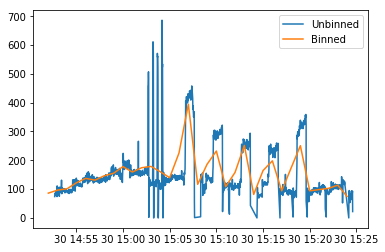

In [9]:
times = df_mean.index
power = df_mean['power'].values
plt.plot(df['time'], df['power'], label='Unbinned')
plt.plot(times, power, label='Binned')
plt.legend(); None

Let's make a power curve (lowest resolution of one minute)...

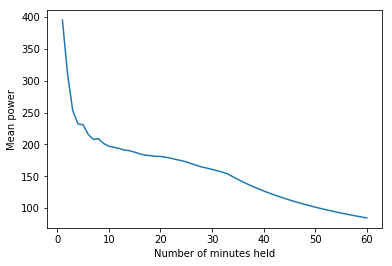

In [10]:
n_minute_power = tda.get_power_curve(power, min_n=1, max_n=60)
plt.plot(range(1, 61), n_minute_power)
plt.xlabel('Number of minutes held')
plt.ylabel('Mean power'); None

We can go to better resolution, if we interpolate the dataset. First we need to reindex by time and check for duplicates (where we've got more than one value recored for a given second). We'll keep the mean value

In [11]:
time_indexed_df = df.set_index('time')
duplicate_indices = time_indexed_df.index[time_indexed_df.index.duplicated('first')]
duplicate_means = time_indexed_df[time_indexed_df.index.duplicated(False)].groupby('time').mean()
time_indexed_df = pd.concat((
    time_indexed_df[~time_indexed_df.index.duplicated(False)],
    duplicate_means
), sort=True)

In [12]:
all_times = np.arange(df['time'].values[0], df['time'].values[-1] + 1, dtype='datetime64[s]')

In [13]:
df_interpolated = time_indexed_df.reindex(all_times).interpolate('linear')
df_interpolated.head()

,binned_time,cadence,distance,hr,power,speed
time,,,,,,
2019-01-30 14:52:41,2019-01-30 14:52:00,60.0,7.11,109.0,74.0,7.11
2019-01-30 14:52:42,2019-01-30 14:52:00,60.0,21.57,109.0,78.0,7.27
2019-01-30 14:52:43,2019-01-30 14:52:00,62.0,28.85,108.0,85.0,7.50
2019-01-30 14:52:44,2019-01-30 14:52:00,63.0,36.03,108.0,85.0,7.49
2019-01-30 14:52:45,2019-01-30 14:52:00,63.0,43.19,106.0,84.0,7.45


Does this interpolated plot look about right?

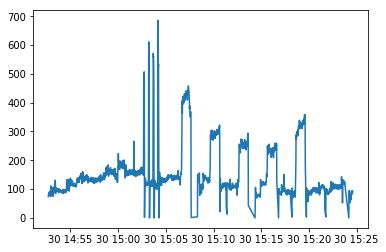

In [14]:
plt.plot(df_interpolated.index, df_interpolated['power'])

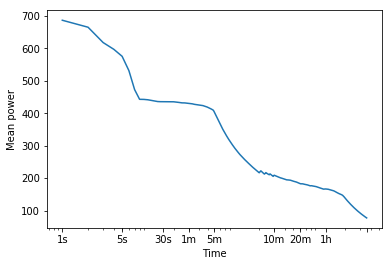

In [15]:
t_to_calc = np.arange(1, 3601)
n_second_power = tda.get_power_curve(
    df_interpolated['power'].values,
    t_to_calc[0], t_to_calc[-1]
)
plt.plot(t_to_calc, n_second_power)
plt.xlabel('Time')
plt.ylabel('Mean power')
plt.xscale('log')
plt.xticks(
  [1, 5, 15, 30, 60, 5*60, 10 * 60, 20 * 60, 60 * 60],
  ['1s', '5s', '30s', '1m', '5m', '10m', '20m', '1h']
);

In [16]:
print('1 second power:  {:.0f}W'.format(
    n_second_power[np.where(t_to_calc == 1)][0]
))
print('5 second power:  {:.0f}W'.format(
    n_second_power[np.where(t_to_calc == 5)][0]
))
print('30 second power: {:.0f}W'.format(
    n_second_power[np.where(t_to_calc == 30)][0]
))
print('1 minute power:  {:.0f}W'.format(
    n_second_power[np.where(t_to_calc == 60)][0]
))
print('5 minute power:  {:.0f}W'.format(
    n_second_power[np.where(t_to_calc == 5*60)][0]
))
print('20 minute power: {:.0f}W'.format(
    n_second_power[np.where(t_to_calc == 20*60)][0]
))

1 second power:  686W
5 second power:  575W
30 second power: 430W
1 minute power:  402W
5 minute power:  209W
20 minute power: 167W


And what about the watts per kilo?

In [17]:
weight = 72 # kg

In [18]:
print('1 second W/kg:  {:.2f} W/kg'.format(
    n_second_power[np.where(t_to_calc == 1)][0]/weight
))
print('5 second W/kg:  {:.2f} W/kg'.format(
    n_second_power[np.where(t_to_calc == 5)][0]/weight
))
print('30 second W/kg: {:.2f} W/kg'.format(
    n_second_power[np.where(t_to_calc == 30)][0]/weight
))
print('1 minute W/kg:  {:.2f} W/kg'.format(
    n_second_power[np.where(t_to_calc == 60)][0]/weight
))
print('5 minute W/kg:  {:.2f} W/kg'.format(
    n_second_power[np.where(t_to_calc == 5*60)][0]/weight
))
print('20 minute W/kg: {:.2f} W/kg'.format(
    n_second_power[np.where(t_to_calc == 20*60)][0]/weight
))

1 second W/kg:  9.53 W/kg
5 second W/kg:  7.99 W/kg
30 second W/kg: 5.98 W/kg
1 minute W/kg:  5.59 W/kg
5 minute W/kg:  2.90 W/kg
20 minute W/kg: 2.31 W/kg
